In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Building a spam filter

In [3]:
# Grab and process the raw data.
data_path = ("datasets/smsspamCollection/SMSSpamCollection")

sms_raw = pd.read_table('datasets/smsspamCollection/SMSSpamCollection',  header=None)

sms_raw.columns = ['spam', 'message']

In [4]:
sms_raw.head(10) 

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [5]:
sms_raw.spam.value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

In [6]:
sms_raw.shape

(5572, 2)

In [7]:
# checking if the the messages have this unique keywords

keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent', 'money'] 


for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [9]:
sms_raw.head(20)

,spam,message,click,offer,winner,buy,free,cash,urgent,money
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,False,False,False,False,False,False
1,ham,Ok lar... Joking wif u oni...,False,False,False,False,False,False,False,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,False,False,False,False,False,False,False,False
3,ham,U dun say so early hor... U c already then say...,False,False,False,False,False,False,False,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,False,False,False,False,False,False,False
5,spam,FreeMsg Hey there darling it's been 3 week's n...,False,False,False,False,False,False,False,False
6,ham,Even my brother is not like to speak with me. ...,False,False,False,False,False,False,False,False
7,ham,As per your request 'Melle Melle (Oru Minnamin...,False,False,False,False,False,False,False,False
8,spam,WINNER!! As a valued network customer you have...,False,False,False,False,False,False,False,False
9,spam,Had your mobile 11 months or more? U R entitle...,False,False,False,False,True,False,False,False


In [10]:
# checking for uppercase messages as they are a good chance to be scam
sms_raw['allcaps'] = sms_raw.message.str.isupper() #caps or not 

In [11]:
sms_raw[sms_raw.allcaps==True].head(2)

,spam,message,click,offer,winner,buy,free,cash,urgent,money,allcaps
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,False,False,False,False,False,False,False,False,True
43,ham,WHO ARE YOU SEEING?,False,False,False,False,False,False,False,False,True


In [12]:
sms_raw.corr()

,click,offer,winner,buy,free,cash,urgent,money,allcaps
click,1.000000,-0.001762,-0.001392,-0.003124,-0.005735,-0.003454,-0.001245,-0.002721,-0.004301
offer,-0.001762,1.000000,-0.002275,-0.005106,0.109339,-0.005646,-0.002035,-0.004447,-0.007030
winner,-0.001392,-0.002275,1.000000,-0.004035,-0.007407,0.199283,-0.001608,0.048007,-0.005554
buy,-0.003124,-0.005106,-0.004035,1.000000,-0.016623,-0.010011,-0.003608,0.015239,-0.012465
free,-0.005735,0.109339,-0.007407,-0.016623,1.000000,-0.008204,-0.006624,-0.001611,-0.022883
cash,-0.003454,-0.005646,0.199283,-0.010011,-0.008204,1.000000,0.041561,-0.008718,-0.013782
urgent,-0.001245,-0.002035,-0.001608,-0.003608,-0.006624,0.041561,1.000000,-0.003142,-0.004967
money,-0.002721,-0.004447,0.048007,0.015239,-0.001611,-0.008718,-0.003142,1.000000,-0.010855
allcaps,-0.004301,-0.007030,-0.005554,-0.012465,-0.022883,-0.013782,-0.004967,-0.010855,1.000000


<AxesSubplot:>

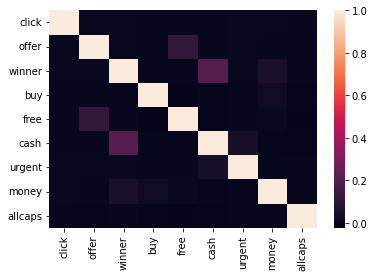

In [13]:
sns.heatmap(sms_raw.corr())

Most of the words show strong independence from each other. The only exceptions are free:offer and cash:winner. 



In [14]:
# build out our training data

data = sms_raw[keywords + ['allcaps']]

target = sms_raw['spam']

In [17]:
data.head()

,click,offer,winner,buy,free,cash,urgent,money,allcaps
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False


In [18]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 5572 points : 604


In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
confusion_matrix(target,  y_pred)


array([[4770,   55],
       [ 549,  198]])